In [1]:
# Install google earth engine python API
# https://developers.google.com/earth-engine/python_install_manual
%pip install earthengine-api --upgrade pandas geopandas
%pip install scipy folium

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import geopandas as gpd
# Plot the bounds on the map with folium
# https://python-visualization.github.io/folium/
import folium
import json
import ee
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import folium
import time
%matplotlib inline

ee.Authenticate(
    # force=True
)
ee.Initialize()

In [3]:

city_name = 'Kryvyi_Rih'
# Define the time range
start_date = '2022-02-16'
# end_date = '2022-02-24'
end_date = '2024-02-11'
# orbitProperties_pass='DESCENDING'
# relativeOrbitNumber_start=65
gdf_boundaries = gpd.read_file(f"{city_name.replace(' ', '_')}_boundary.geojson")

In [4]:

# Get bounding box of gdf_boundaries
bounds = gdf_boundaries.bounds
bounds = bounds.to_dict(orient='list')
bounds = {
    'minlat': bounds['miny'][0],
    'maxlat': bounds['maxy'][0],
    'minlon': bounds['minx'][0],
    'maxlon': bounds['maxx'][0]
}

# Make geojson from bounds
geoJSON = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['minlat']]
                    ]
                ]
            }
        }
    ]
}

center=[(bounds['minlat'] + bounds['maxlat']) / 2, (bounds['minlon'] + bounds['maxlon']) / 2]
bounds

{'minlat': 47.6503431,
 'maxlat': 48.1954303,
 'minlon': 33.139351,
 'maxlon': 33.5987019}

In [5]:


buffer_offset_x = -0.1
buffer_offset_y = -0.1
geoJSON_buffered = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry":
            {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y]
                    ]
                ]
            }
        }
    ]
}

mp = folium.Map(location=center, zoom_start=10)
folium.GeoJson(json.dumps(geoJSON)).add_to(mp)
folium.GeoJson(json.dumps(geoJSON_buffered)).add_to(mp)
mp

In [6]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [7]:
aoi = ee.Geometry.Polygon(geoJSON['features'][0]['geometry']['coordinates'])
aoi_sub = ee.Geometry.Polygon(geoJSON_buffered['features'][0]['geometry']['coordinates'])

In [8]:

test_col = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date)))
# Show relativeOrbitNumber_start for the first image in the collection
relativeOrbitNumber_start = test_col.first().get('relativeOrbitNumber_start').getInfo()
# Show orbitProperties_pass for the first image in the collection
orbitProperties_pass = test_col.first().get('orbitProperties_pass').getInfo()
print(relativeOrbitNumber_start, orbitProperties_pass)

# to define orbitProperties_pass and relativeOrbitNumber_start for your case use this link https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2

# Create an ImageCollection for the given time range and AOI
ffa_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start))
              .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
              .sort('system:time_start'))

ffa_fl_collection = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start))
              .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYY-MM-dd')))
              .sort('system:time_start'))

ffa_db = ee.Image(ffa_collection.filterDate(ee.Date(start_date), ee.Date(end_date)).first().clip(aoi))

all_dates = (ffa_fl_collection.aggregate_array('date')
                 .getInfo())
print(all_dates)
first_date = all_dates[0]
first_date_p1 = (pd.to_datetime(first_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
last_date = all_dates[-1]
last_date_p1 = (pd.to_datetime(last_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

print(f'First date: {first_date}:{first_date_p1}, last date: {last_date}:{last_date_p1}')


65 DESCENDING
['2022-02-18', '2022-03-14', '2022-03-26', '2022-04-07', '2022-04-19', '2022-05-01', '2022-05-13', '2022-05-25', '2022-06-06', '2022-06-18', '2022-06-30', '2022-07-12', '2022-07-24', '2022-08-05', '2022-08-17', '2022-08-29', '2022-09-10', '2022-09-22', '2022-10-04', '2022-10-16', '2022-10-28', '2022-11-09', '2022-11-21', '2022-12-03', '2022-12-15', '2022-12-27', '2023-01-08', '2023-01-20', '2023-02-01', '2023-02-13', '2023-02-25', '2023-03-09', '2023-03-21', '2023-04-02', '2023-04-14', '2023-04-26', '2023-05-08', '2023-05-20', '2023-06-01', '2023-06-13', '2023-06-25', '2023-07-07', '2023-07-19', '2023-07-31', '2023-08-12', '2023-08-24', '2023-09-05', '2023-09-17', '2023-09-29', '2023-10-11', '2023-10-23', '2023-11-04', '2023-11-16', '2023-11-28', '2023-12-10', '2023-12-22', '2024-01-03', '2024-01-15', '2024-01-27', '2024-02-08']
First date: 2022-02-18:2022-02-19, last date: 2024-02-08:2024-02-09


In [9]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
mp = folium.Map(location=location, zoom_start=10)

# Add the S1 rgb composite to the map object.
mp.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')
folium.GeoJson(json.dumps(geoJSON)).add_to(mp)
# Add a layer control panel to the map.
mp.add_child(folium.LayerControl())

# Display the map.
display(mp)

Mean:  1.755338983022968
Variance:  162.45490604801736
Hist:  [[0, 29548], [0.01, 43884], [0.02, 62352], [0.03, 80084], [0.04, 104452], [0.05, 125628], [0.06, 155713.02352941176], [0.07, 187266.5019607843], [0.08, 225635.3843137255], [0.09, 271199.0901960784], [0.1, 322698.8745098039], [0.11, 371163.55686274514], [0.12, 432053.7882352941], [0.13, 497032.5176470588], [0.14, 566102.8274509803], [0.15, 646036.2392156865], [0.16, 730740.3764705881], [0.17, 804920.5294117645], [0.18, 921076.5058823527], [0.19, 1018451.6156862744], [0.2, 1135680.3686274511], [0.21, 1225736.090196078], [0.22, 1343934.6901960783], [0.23, 1466688.5333333334], [0.24, 1579818.870588235], [0.25, 1702912.9686274517], [0.26, 1812447.8274509804], [0.27, 1935891.6470588231], [0.28, 2066667.3647058823], [0.29, 2210222.1450980394], [0.3, 2317459.4705882357], [0.31, 2450118.8039215677], [0.32, 2568921.086274511], [0.33, 2692704.643137255], [0.34, 2837343.874509804], [0.35000000000000003, 2936246.333333333], [0.36, 306095

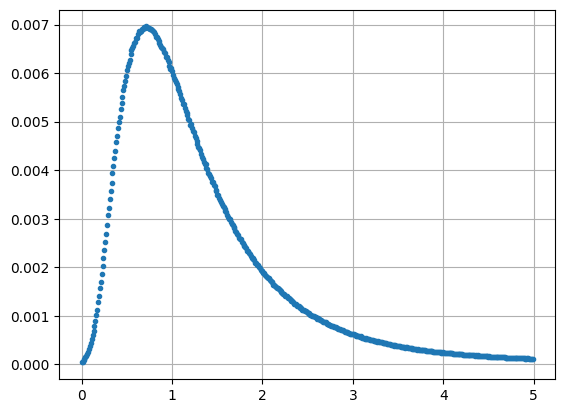

In [10]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date(first_date), ee.Date(first_date_p1))
                .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start)).first().clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date(last_date), ee.Date(last_date_p1))
                .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start)).first().clip(aoi))

ratio = im1.divide(im2)
# print(ratio.getInfo())
hist = ratio.reduceRegion(
    ee.Reducer.fixedHistogram(0, 5, 500), 
    aoi_sub,
    scale=1,  # specify an appropriate scale for your data
    maxPixels=3e9,
    bestEffort=True
  ).get('VV').getInfo()
mean = ratio.reduceRegion(
    ee.Reducer.mean(), 
    aoi_sub,
      scale=1,  # specify an appropriate scale for your data
    maxPixels=3e9,
    bestEffort=True
  ).get('VV').getInfo()
variance = ratio.reduceRegion(
    ee.Reducer.variance(), 
    aoi_sub,
    scale=1,  # specify an appropriate scale for your data
    maxPixels=3e9,
    bestEffort=True
  ).get('VV').getInfo()
print('Mean: ', mean)
print('Variance: ', variance)
print('Hist: ', hist)
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()


In [11]:
im1.bandNames().getInfo()

['VV', 'VH', 'angle']

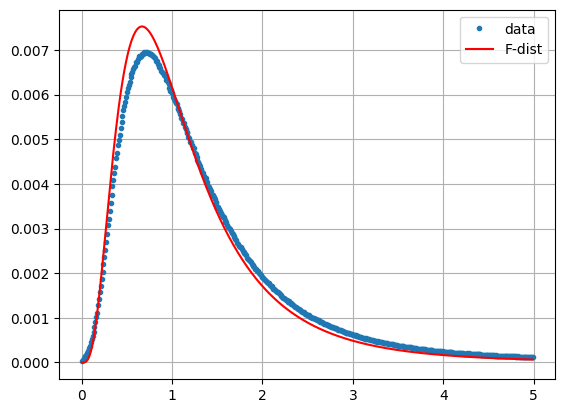

In [12]:
m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

In [13]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

1.755338983022968 1.25
162.45490604801736 0.9375


In [14]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date(first_date), ee.Date(first_date_p1)).first().select('VV').clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date(last_date), ee.Date(last_date_p1)).first().select('VV').clip(aoi))
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=10)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 
                 'palette': ['black', 'white']
                 }, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

In [15]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)


# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='cartodb positron',
    zoom_start=10)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 
                 'palette': ['black', 'white']
                 }, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 
                 'palette': ['black', 'blue', 'red']
                 },
                'Change Map')
mp.add_child(folium.LayerControl())

display(mp)

In [16]:
def det(im):
  return im.expression('b(0) * b(1)')

# Number of looks.
m = 5

im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date(first_date), ee.Date(first_date_p1)).first().select('VV', 'VH').clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date(last_date), ee.Date(last_date_p1)).first().select('VV', 'VH').clip(aoi))

m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

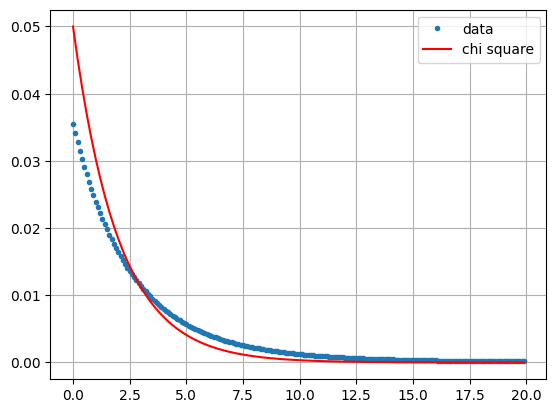

In [17]:
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), aoi,
    scale=1,  # specify an appropriate scale for your data
    maxPixels=3e9,
    bestEffort=True
).get('VV').getInfo()
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

In [18]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date(first_date), ee.Date(first_date_p1)).first().clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date(last_date), ee.Date(last_date_p1)).first().clip(aoi))
def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
      using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The observed test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Project onto map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(p_value,
                {'min': 0,'max': 1, 'palette': ['black', 'white']}, 'P-value')
mp.add_child(folium.LayerControl())